In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, f1_score, confusion_matrix
import spacy
import re
import nltk; nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kristjan.roosild/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
am = pd.read_csv('/Users/kristjan.roosild/kool/MachineLearning/projekt/adverse_media_training.csv')
nam = pd.read_csv('/Users/kristjan.roosild/kool/MachineLearning/projekt/non_adverse_media_training.csv')

am_confirmed = am.loc[(am.label == 'am') | (am.label == 'am ')]
am_confirmed = pd.concat([am_confirmed, nam.loc[nam.label == 'am']])

nam_confirmed = nam.loc[(nam.label == 'nam') | (nam.label == 'random')]
nam_confirmed = pd.concat([nam_confirmed, am.loc[(am.label == 'nam') | (am.label == 'random')]])

am_confirmed['label'] = 1
nam_confirmed['label'] = 0

# Creating the train dataset
data = pd.concat([am_confirmed, nam_confirmed])
print(data.shape)
print()
print(data['label'].value_counts())

(729, 11)

1    411
0    318
Name: label, dtype: int64


In [3]:
data["article"] = data["title"] + " " + data["article"]
data.drop(["title"], axis =1)

data = data[['article', 'label']].copy()

data['article'] = data['article'].astype('str')
data['label'] = data['label'].astype('int')

data = data.sample(frac = 1, random_state=42)
data = data.reset_index()
data = data.drop(['index'], axis=1)

In [4]:
from eda import *


#number of augmented sentences to generate per original sentence
num_aug = 9 #default

#how much to replace each word by synonyms
alpha_sr = 0.1#default

#how much to insert new words that are synonyms
alpha_ri = 0.1#default

#how much to swap words
alpha_rs = 0.1#default

#how much to delete words
p_rd = 0.1#default

if alpha_sr == alpha_ri == alpha_rs == p_rd == 0:
     ap.error('At least one alpha should be greater than zero')
# , alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0, p_rd=0

In [5]:
def augment_article(article):
    doc = nlp(article)

    all_augmented_sentences = []

    # augment sentences
    for sent in doc.sents:
        try:
            augmented_sentence = eda(sent.text, num_aug=1, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0, p_rd=0)[0]
            all_augmented_sentences.append(augmented_sentence)

        except (ValueError, IndexError) as err:
            pass
        
    return ' '.join(all_augmented_sentences)

augment_article_v = np.vectorize(augment_article)

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# The regex below can be modified later on.
def lemmatize(article):
    article = re.sub(r'http\S+', '', article)
    article = re.sub(r"#(\w+)", '', article)
    article = re.sub(r"@(\w+)", '', article)
    article = re.sub(r'[^\w\s]', '', article)
    article = re.sub(r'\w*\d\w*','', article)
    article = re.sub(' +',' ', article)
    article = article.strip().lower()
    
    doc = nlp(article)
    lemmatized_article = " ".join([token.lemma_ for token in doc if (token.is_stop==False)]) 
    
    return lemmatized_article

lemmatize_v = np.vectorize(lemmatize)


In [7]:
df = data.copy()

x_train, x_val, y_train, y_val = train_test_split(df['article'].to_numpy(), 
                                                    df['label'].to_numpy(), 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify=df['label'])

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(656,) (73,) (656,) (73,)


In [8]:
print('Now, lemmatizing and augmenting...')
x_train = np.append(augment_article_v(x_train), lemmatize_v(x_train))
y_train = np.append(y_train, y_train)

x_val = np.append(augment_article_v(x_val), lemmatize_v(x_val))
y_val = np.append(y_val, y_val)

print('Finished lemmatizing and augmenting:')


print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

Now, lemmatizing and augmenting...
Finished lemmatizing and augmenting:
(1312,) (146,) (1312,) (146,)


In [9]:
ngram_vectorizer = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 3))
print(ngram_vectorizer)

TfidfVectorizer(max_df=0.5, max_features=40000, min_df=5, ngram_range=(1, 3),
                stop_words='english')


In [10]:
import random
ngram_vectorizer.fit(x_train)
features = ngram_vectorizer.get_feature_names()

In [11]:
tfidf_train = ngram_vectorizer.transform(x_train)
tfidf_validation = ngram_vectorizer.transform(x_val)

In [12]:
doc_array = tfidf_train.toarray()
frequency_matrix = pd.DataFrame(doc_array, columns = features)
frequency_matrix.head(10)

,ab,ab initio,abandon,abandoned,abc,abd,abduct,abduction,abdul,abdul majid,...,zimbabwe african,zimbabwe african national,zimbabwe african peoples,zimbabwe anti,zimbabwe anticorruption,zimbabwe anticorruption commission,zimbabwean,zimbabweans,zimbabwes,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.107635,0.0,0.0,0.16718,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.08048,0.148446,0.127398,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0


In [13]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(model, tfidf_train, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()


Best alpha:  0.1


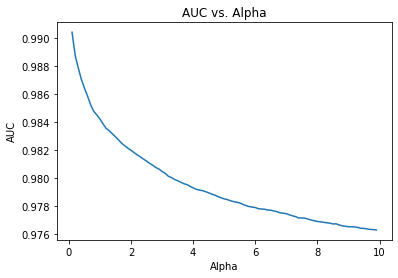

In [14]:
res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [15]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9402
Accuracy: 89.73%


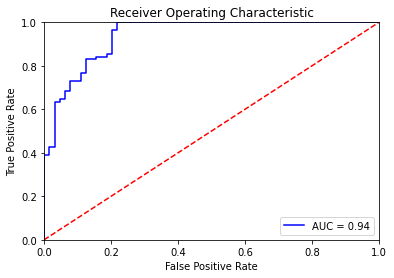

In [16]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(tfidf_train, y_train)
probs = nb_model.predict_proba(tfidf_validation)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [17]:
train_preds_nb = nb_model.predict(tfidf_train)
val_preds_nb = nb_model.predict(tfidf_validation)

train_f1_score_nb = f1_score(y_train, train_preds_nb)
val_f1_score_nb = f1_score(y_val, val_preds_nb)

train_accuracy_nb = accuracy_score(y_train, train_preds_nb)
val_accuracy_nb = accuracy_score(y_val, val_preds_nb)

In [18]:
print('Prediction accuracy for naive bayes model on train data:', round(train_accuracy_nb*100, 3))
print('Prediction accuracy for naive bayes model on validation data:', round(val_accuracy_nb*100, 3))

print()

print('F1 score for naive bayes model on train data:', round(train_f1_score_nb*100, 3))
print('F1 score for naive bayes model on validation data:', round(val_f1_score_nb*100, 3))

Prediction accuracy for naive bayes model on train data: 98.704
Prediction accuracy for naive bayes model on validation data: 89.726

F1 score for naive bayes model on train data: 98.847
F1 score for naive bayes model on validation data: 91.525


### First
* Prediction accuracy for naive bayes model on train data: 96.494
* Prediction accuracy for naive bayes model on validation data: 90.411

* F1 score for naive bayes model on train data: 96.879
* F1 score for naive bayes model on validation data: 91.954

### With augmented sentences, default params, num_aug=1

Prediction accuracy for naive bayes model on train data: 98.857
Prediction accuracy for naive bayes model on validation data: 88.356

F1 score for naive bayes model on train data: 98.982
F1 score for naive bayes model on validation data: 90.286

In [19]:
public_test = pd.read_csv('/Users/kristjan.roosild/kool/MachineLearning/projekt/public_test.csv')

In [20]:
!pwd

/Users/kristjan.roosild/kool/MachineLearning/projekt/ut-ml-adverse-media/Canberk/NaiveBayes


In [21]:
public_test["article"] = public_test["title"] + " " + public_test["article"]
public_test = public_test.drop(["title"], axis =1)

In [22]:
public_test_lemmatized = public_test[['article', 'label']].copy()
public_test_lemmatized["article"] = public_test_lemmatized["article"].apply(lemmatize)
public_test_lemmatized = public_test_lemmatized.reset_index()
public_test_lemmatized = public_test_lemmatized.drop(['index'], axis=1)
public_test_lemmatized

tfidf_public_test = ngram_vectorizer.transform(public_test_lemmatized.article)

In [23]:
public_test_preds_nb = nb_model.predict(tfidf_public_test)

public_test_accuracy_nb = accuracy_score(public_test.label, public_test_preds_nb)

public_test_f1_score_nb = f1_score(public_test.label, public_test_preds_nb)


print('Prediction accuracy for naive bayes model on public test data:', round(public_test_accuracy_nb*100, 3))

print()

print('F1 score for naive bayes model on public test data:', round(public_test_f1_score_nb*100, 3))

Prediction accuracy for naive bayes model on public test data: 89.308

F1 score for naive bayes model on public test data: 91.542


#### With text augmentation - double amount of articles
Prediction accuracy for naive bayes model on public test data: 89.308

F1 score for naive bayes model on public test data: 91.542



#### Using Karl's cleaning and lemmatization, title added to article

Prediction accuracy for naive bayes model on public test data: 90.566

F1 score for naive bayes model on public test data: 92.537



#### With original cleaned_lemmatized_text.csv

Prediction accuracy for naive bayes model on public test data: 91.824

F1 score for naive bayes model on public test data: 93.467